# On Mnist

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as FA
# from torchsummary import summary
from torchvision import datasets, transforms


In [21]:

vis = False


class DoGConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DoGConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Learnable parameters for the standard deviations of the Gaussians
        self.log_std1 = nn.Parameter(torch.randn(out_channels, in_channels, 1, 1))  # Std for first Gaussian
        self.log_std2 = nn.Parameter(torch.randn(out_channels, in_channels, 1, 1))  # Std for second Gaussian

    def forward(self, x):
        std1 = torch.exp(self.log_std1)
        std2 = torch.exp(self.log_std2)

        dog = torch.zeros((x.size(0), self.out_channels, x.size(2), x.size(3)), device=x.device)

        for i in range(self.out_channels):
            for j in range(self.in_channels):
                dog[:, i:i+1] += self.compute_dog(x[:, j:j+1], kernel_size=self.kernel_size, sigma1=std1[i, j], sigma2=std2[i, j])

#         if vis:
#             plot_feature_maps(dog, title="DoG Result")

        return dog 
    


    def gaussian_kernel(self,size, sigma):
        """Generate a 2D Gaussian kernel using meshgrid coordinates."""
        # Define the coordinate range based on the kernel size
        ax = torch.linspace(-(size - 1) / 2., (size - 1) / 2., size)
        xx, yy = torch.meshgrid(ax, ax)
        xx,yy=xx.to(device),yy.to(device)

        # Calculate the 2D Gaussian kernel
        kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))

        # Normalize the kernel so that the sum of all its elements will be 1.
        kernel = kernel / torch.sum(kernel)

        return kernel

    def apply_gaussian_blur(self,image, kernel_size, sigma):
        """Applies Gaussian blur to an image using a 2D Gaussian kernel."""
        kernel = self.gaussian_kernel(kernel_size, sigma).to(image.device)
        kernel = kernel.view(1, 1, kernel_size, kernel_size)  # Shape the kernel for convolution
        padding = kernel_size // 2
        return F.conv2d(image, kernel, padding=padding, groups=image.shape[1])

    def compute_dog(self,image, kernel_size, sigma1, sigma2):
        """Computes the difference of Gaussians for an image."""
        blur1 = self.apply_gaussian_blur(image, kernel_size, sigma1)
        blur2 = self.apply_gaussian_blur(image, kernel_size, sigma2)
        dog = blur1 - blur2
        return dog

class DoGNet(nn.Module):
    def __init__(self, num_pyramid_levels=3):
        super(DoGNet, self).__init__()
        self.num_pyramid_levels = num_pyramid_levels

        # First custom convolutional layer
        self.convs = nn.ModuleList([DoGConv(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
                                    for _ in range(num_pyramid_levels)])

        self.conv2 = nn.Conv2d(in_channels=32 * num_pyramid_levels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.pool = nn.AdaptiveAvgPool2d((8, 8))
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Linear(32, 10)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        pyramid = self.generate_pyramid(x, self.num_pyramid_levels)

        pyramid_features = []
        for i, level in enumerate(pyramid):
            features = self.convs[i](level)
            features = F.relu(features)

            if i > 0:
                features = F.interpolate(features, size=pyramid[0].shape[2:], mode='bicubic', align_corners=False)

            pyramid_features.append(features)

        x = self.attention_module(pyramid_features)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.global_max_pool(x)
        x = x.view(x.size(0), -1)
        # x = self.dropout(x)
        x = self.fc1(x)
#         x = nn.Softmax(x)

        return x
    def generate_pyramid(self,image, num_levels):
        pyramid = [image]
        for i in range(1, num_levels):
            downsampled_image = F.interpolate(pyramid[-1], scale_factor=0.5, mode='bicubic', align_corners=False)
            pyramid.append(downsampled_image)
        return pyramid


class ScaleAttentionModule(nn.Module):
    def __init__(self, channels, num_scales):
        super(ScaleAttentionModule, self).__init__()
        self.channels = channels
        self.num_scales = num_scales
        # Attention over scales
        self.scale_attention = nn.MultiheadAttention(embed_dim=channels, num_heads=8)

    def forward(self, pyramid_features):
        # Each feature in pyramid_features: [batch_size, channels, height, width]
        batch_size, channels, height, width = pyramid_features[0].shape

        # Stack features over scales: [batch_size, num_scales, channels, height, width]
        features = torch.stack(pyramid_features, dim=1)

        # Reshape to [batch_size, num_scales, channels, height * width]
        features = features.view(batch_size, self.num_scales, channels, -1)

        # Transpose to [height * width, batch_size, num_scales, channels]
        features = features.permute(3, 0, 1, 2)

        # Flatten batch and spatial dimensions: [height * width * batch_size, num_scales, channels]
        features = features.reshape(-1, self.num_scales, channels)

        # Transpose for MultiheadAttention: [num_scales, height * width * batch_size, channels]
        features = features.transpose(0, 1)

        # Apply attention over scales
        attn_output, _ = self.scale_attention(features, features, features)
        # attn_output: [num_scales, height * width * batch_size, channels]

        # Sum over scales: [height * width * batch_size, channels]
        attn_output = attn_output.sum(dim=0)

        # Reshape back to [batch_size, channels, height, width]
        attn_output = attn_output.view(height * width, batch_size, channels)
        attn_output = attn_output.permute(1, 2, 0).view(batch_size, channels, height, width)

        return attn_output





In [22]:

# Example input tensor with batch size 64, 1 channel, and image size 28x28


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DoGNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

37450


In [23]:


trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

for epoch in range(10): # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()


        optimizer.step()




        running_loss += loss.item()
        vis=False
        if i % 100 == 99:  # Print every 100 batches
            vis=True
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")


/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[1, 100] loss: 1.824
[1, 200] loss: 0.680
[1, 300] loss: 0.407
[1, 400] loss: 0.343
[1, 500] loss: 0.266
[1, 600] loss: 0.247
[1, 700] loss: 0.215
[1, 800] loss: 0.206
[1, 900] loss: 0.195
[2, 100] loss: 0.167
[2, 200] loss: 0.174
[2, 300] loss: 0.160
[2, 400] loss: 0.161
[2, 500] loss: 0.147
[2, 600] loss: 0.129
[2, 700] loss: 0.141
[2, 800] loss: 0.135
[2, 900] loss: 0.136
[3, 100] loss: 0.136
[3, 200] loss: 0.108
[3, 300] loss: 0.133
[3, 400] loss: 0.116
[3, 500] loss: 0.108
[3, 600] loss: 0.114
[3, 700] loss: 0.115
[3, 800] loss: 0.088
[3, 900] loss: 0.105
[4, 100] loss: 0.102
[4, 200] loss: 0.090
[4, 300] loss: 0.087
[4, 400] loss: 0.079
[4, 500] loss: 0.086
[4, 600] loss: 0.108
[4, 700] loss: 0.109
[4, 800] loss: 0.098
[4, 900] loss: 0.097
[5, 100] loss: 0.077
[5, 200] loss: 0.086
[5, 300] loss: 0.095
[5, 400] loss: 0.081
[5, 500] loss: 0.077
[5, 600] loss: 0.085
[5, 700] loss: 0.082
[5, 800] loss: 0.082
[5, 900] loss: 0.083
[6, 100] loss: 0.091
[6, 200] loss: 0.071
[6, 300] loss

In [26]:
torch.save(model, 'model.pth')

In [24]:

def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    return accuracy, precision, recall, f1
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
accuracy, precision, recall, f1 = test_model(model, testloader)


Accuracy: 0.9825
Precision: 0.9828
Recall: 0.9822
F1-Score: 0.9824


test without learn

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('/kaggle/input/mnist_new/pytorch/default/1/model (1).pth', weights_only=False).to(device)


In [9]:

def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate precision, recall,7 f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    return accuracy, precision, recall, f1
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
accuracy, precision, recall, f1 = test_model(model, testloader)


Accuracy: 0.9827
Precision: 0.9827
Recall: 0.9826
F1-Score: 0.9826


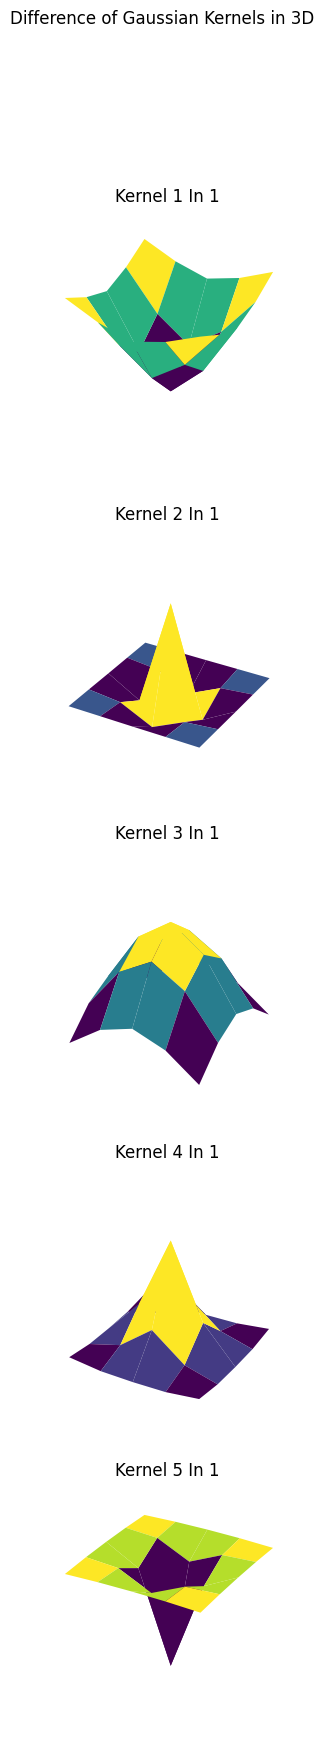

In [28]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
device='cpu'
# def gaussian_kernel(size, sigma):
#         """Generate a 2D Gaussian kernel using meshgrid coordinates."""
#         # Define the coordinate range based on the kernel size
#         ax = torch.linspace(-(size - 1) / 2., (size - 1) / 2., size)
#         xx, yy = torch.meshgrid(ax, ax)
#         xx,yy=xx.to(device),yy.to(device)

#         # Calculate the 2D Gaussian kernel
#         kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))

#         # Normalize the kernel so that the sum of all its elements will be 1.
#         kernel = kernel / torch.sum(kernel)

#         return kernel
def plot_kernels_3d(conv_layer, num_kernels=5):
    """
    Plots the learned kernels from a CustomConv2d layer after training in 3D.
    
    Args:
        conv_layer: The CustomConv2d layer from which to extract and plot the kernels.
        num_kernels: Number of kernels to plot (default: 5).
    """
    # Extract learned standard deviations
    std1 = torch.exp(conv_layer.log_std1).detach().cpu()
    std2 = torch.exp(conv_layer.log_std2).detach().cpu()

    # Create a grid of subplots
    num_out_channels = min(num_kernels, conv_layer.out_channels)
    
    fig = plt.figure(figsize=(conv_layer.in_channels * 4, num_out_channels * 4))
    fig.suptitle('Difference of Gaussian Kernels in 3D')

    # Loop through output channels (kernels)
    for i in range(num_out_channels):
        for j in range(conv_layer.in_channels):
            ax = fig.add_subplot(num_out_channels, conv_layer.in_channels, i * conv_layer.in_channels + j + 1, projection='3d')

            # Create the 2D Gaussian kernels based on learned std
            gaussian1 = gaussian_kernel(conv_layer.kernel_size, std1[i, j])
            gaussian2 = gaussian_kernel(conv_layer.kernel_size, std2[i, j])
            dog_kernel = (gaussian1 - gaussian2).cpu().numpy()

            # Generate X and Y coordinates for 3D plot
            x = np.linspace(-conv_layer.kernel_size // 2, conv_layer.kernel_size // 2, conv_layer.kernel_size)
            y = np.linspace(-conv_layer.kernel_size // 2, conv_layer.kernel_size // 2, conv_layer.kernel_size)
            x, y = np.meshgrid(x, y)

            # Plot the kernel in 3D
            ax.plot_surface(x, y, dog_kernel, cmap='viridis')

            ax.set_title(f'Kernel {i+1} In {j+1}')
            ax.set_zlim(dog_kernel.min(), dog_kernel.max())
            ax.axis('off')  # Hide axes for better visualization

    plt.show()

# Example usage after training:
# Assuming `model` is an instance of `SimpleCNN`
plot_kernels_3d(model.convs[0])
